In [1]:
import pandas as pd

df = pd.read_csv(r'/kaggle/input/iemocap-three-values-spectrogram/df_iemocap.csv')
df.head()

,start_time,end_time,wav_file,emotion,val,act,dom
0,5.8300,8.3081,Ses01F_script02_2_F000,neu,3.0,1.5,2.5
1,9.5800,11.4525,Ses01F_script02_2_F001,neu,2.5,2.0,3.0
2,13.2797,17.0500,Ses01F_script02_2_F002,xxx,2.5,2.5,2.5
3,21.8300,29.7100,Ses01F_script02_2_F003,xxx,2.5,3.5,3.5
4,31.2100,43.4739,Ses01F_script02_2_F004,xxx,2.5,3.5,2.5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 136s 532ms/step - loss: 0.9778 - mae: 0.7414 - val_loss: 0.4837 - val_mae: 0.5495
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 133s 529ms/step - loss: 0.5193 - mae: 0.5736 - val_loss: 0.5585 - val_mae: 0.6040
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 131s 523ms/step - loss: 0.5135 - mae: 0.5681 - val_loss: 0.4915 - val_mae: 0.5567
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 143s 525ms/step - loss: 0.4877 - mae: 0.5539 - val_loss: 0.4878 - val_mae: 0.5525
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 132s 526ms/step - loss: 0.4634 - mae: 0.5388 - val_loss: 0.4986 - val_mae: 0.5731
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 525ms/step - loss: 0.4606 - mae: 0.5399 - val_loss: 0.4671 - val_mae: 0.5327
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 137s 507ms/step - loss: 0.4589 - mae: 0.5333 - val_loss: 0.4664 - val_mae: 0.5479
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 146s 522ms/step - loss: 0.4361 - mae: 0.5252 - val_loss: 0.4767 - val_mae: 0.5507
Epoch 9/20
251/251 ━━━━━

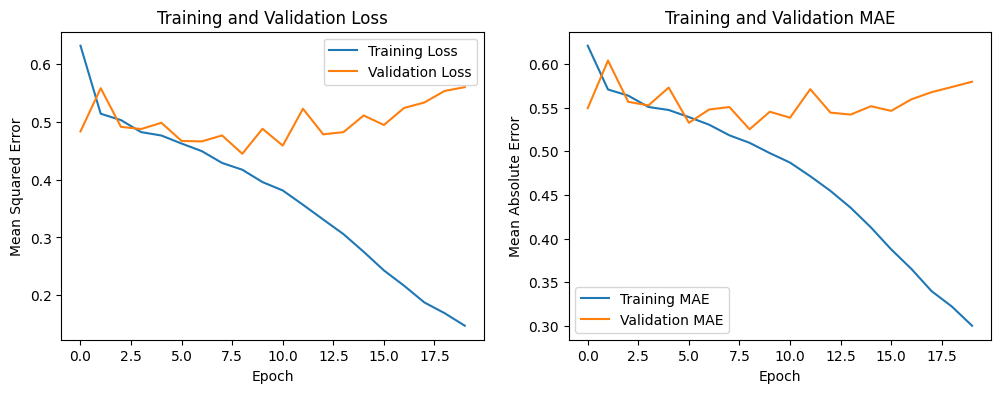

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - loss: 0.5844 - mae: 0.5848
Test Loss: 0.5602748990058899
Test MAE: 0.5796963572502136
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step
Predicted: [3.526907  2.9407032 2.84206  ], True: [4.  3.  3.5]
Predicted: [3.4813952 3.14072   2.5857391], True: [2.  2.5 4. ]
Predicted: [2.6333506 2.7899084 3.0826902], True: [4. 3. 3.]
Predicted: [1.9798825 3.4146514 3.0810695], True: [1.5 3.5 3. ]
Predicted: [1.9362832 2.6644092 2.6956189], True: [2.  3.  3.5]


In [2]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt

df_iemocap = pd.read_csv(r'/kaggle/input/iemocap-three-values-spectrogram/df_iemocap.csv')

spectrogram_dir = '/kaggle/input/iemocap-full-audio-melspectrograms/Iemo_specs_2'

images = []
labels = []

for _, row in df_iemocap.iterrows():
    file_name = row['wav_file']
    spectrogram_path = os.path.join(spectrogram_dir, f"{file_name}.png")
    
    if os.path.exists(spectrogram_path):
        img = load_img(spectrogram_path, color_mode='grayscale', target_size=(128, 128))
        img_array = img_to_array(img) / 255.0  # Normalize image
        
        images.append(img_array)
        labels.append([row['val'], row['act'], row['dom']])

images = np.array(images)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='linear')  
    ])
    return model

input_shape = (128, 128, 1)  
model = create_cnn_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)


plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss')

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.show()

test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

predictions = model.predict(X_test)

for i in range(5):
    print(f"Predicted: {predictions[i]}, True: {y_test[i]}")
